## Molekulardynamik - Simulation eines Lennard-Jones-Fluids

Mit den zuvor hergeleiteten einfachen Gleichungen können wir bereits das Verhalten von Festkörpern, Fluiden und Gasen simulieren. Wir beschränken uns dabei auf ein 2-dimensionales Universum, da damit akzeptable Rechenzeiten möglich und anschauliche Darstellungen einfacher zu erstellen sind.

Da die Größenordnungen bei der Molekulardynamik-Simulation sehr unterschiedlich sind bzw. wir mit sehr kleinen Zahlen arbeiten, ist es sinnvoll, mit [natürlichen Einheiten](https://de.wikipedia.org/wiki/Natürliche_Einheiten) zu rechnen. D.h. wir verwenden ein Einheitensystem, aus dem resultiert, dass $\epsilon_0$, $r_0$ und die Masse eines Atoms $m$ gleich 1 sind. Für das Helium-Atom wäre die Einheit der Energie also $0.00094~\text{eV}$.

Alle anderen Einheiten lassen sich dann daraus ableiten. Z.B. gilt für die Geschwindigkeit:

$$\text{Geschwindigkeit} = \frac{\text{Länge}}{\text{Zeit}} = \sqrt{\frac{\text{Energie}}{\text{Masse}}}$$ 

so dass wir für die Einheit:

$$\sqrt{\frac{0.00094~\text{eV}}{4 \text{u}}} = 150~\frac{\text{m}}{\text{s}}$$

erhalten. Wollen wir also eine Geschwindigkeit von $300~\text{m/s}$ im natürlichen Einheitensystem für Helium ausdrücken ergibt sich ein Wert von $2$.

Eine ähnliche Überlegung:

$$\text{Energie} = \text{Masse}\frac{\text{Länge}^2}{\text{Zeit}^2} \quad \text{bzw.}~~ \text{Zeit} = \text{Länge} \cdot \sqrt{\frac{\text{Masse}}{\text{Energie}}}$$

 liefert uns die Einheit für die Zeit:
 
$$2.64~\text{Å}\cdot\sqrt{\frac{4~\text{u}}{0.00094~\text{eV}}}= 1.76~\text{ps}$$

1 Sekunde hat also im natürlichen Einheitensystem für Helium den Wert $5.68\cdot 10^{11}$.

| Atom    | Masse | Länge | Energie | Temperatur | Geschw. | Zeit | Druck   |
| ------- |:-----:|:-----:|:-------:|:----------:|:-------:|:----:|:-------:|
|         | $m~\text{in u}$ | $r_0~\text{in Å}$ | $\epsilon~\text{in eV}$ | $\epsilon/k_B~\text{in K}$ | $\sqrt{\epsilon/m}~\text{in m/s}$ | $r_0\sqrt{m/\epsilon}~\text{in ps}$ | $\epsilon/r_0^3~\text{in Pa}$ |
| Helium  | 4.0   | 2.64  | 0.00094 | 10.9       | 150     | 1.76 | 8122319  |
| Neon    | 20.2  | 2.74  | 0.00350 | 41.2       | 130     | 2.10 | 27658183 |
| Argon   | 39.9  | 3.35  | 0.01220 | 142        | 172     | 1.95 | 52074662 |
| Krypton | 83.8  | 3.58  | 0.01720 | 199        | 141     | 2.55 | 60035238 |
| Xenon   | 131.3 | 3.80  | 0.02420 | 281        | 133     | 2.84 | 70709892 |

Zunächst importieren wir wieder die benötigten Python-Module:

In [15]:
# Benötigte Bibliotheken einbinden und konfigurieren
from matplotlib import animation, rc
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
from numba import jit, int64, float64, void
from IPython.display import HTML
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rc('font', size=11)

und dann eine Funktion, mit der wir die Kraft und das Lennard-Jones-Potential zwischen zwei Atomen berechnen können:

In [16]:
# Berechnet die Kraft und das Potential zwischen zwei Atomen
# Es wird dabei die Python-Erweiterung Numba verwendet, die
# eine "just-in-time" Kompilierung durchführt, um die Ausführ-
# geschwindigkeit zu erhöhen.
@jit(float64(float64[:], float64[:]), 
     nopython=True, cache=True, nogil=True)
def calc_force_pot_onibyj(rij, fij):
    r = math.sqrt(rij[0]*rij[0]+rij[1]*rij[1])
    if r > 0 and r < 3:
        invrsquare = 1/(r*r)
        a = (24 * (2*invrsquare**7 - invrsquare**4))
        #a = (24 * (2*(1/r)**14 - (1/r)**8))
        fij[0] = a * rij[0]
        fij[1] = a * rij[1] 
        pot = 4 * (invrsquare**6 - invrsquare**3)
    else:
        fij[0] = 0.0
        fij[1] = 0.0
        pot = 0.0
    return pot

Als nächstes definieren wir die Funktion, mit der die aufsummierten Kräfte und Potentiale für jedes Atom berechnet werden: 

In [17]:
# Berechnet die Kräfte und das Potential zwischen allen Atomen
@jit(float64(float64[:, :], float64[:,:], int64, float64[:,:], 
          float64[:], float64[:]),
     nopython=True, cache=True, nogil=True)
def calc_forces_pot(xy, v, N, f, pot, virial):
    E = 0.0
    f[:] = 0.0
    pot[:] = 0.0
    fij = np.zeros(2)
    potential = 0.0
    virial[:] = 0.0
    
    for i in range(0,N):
        for j in range(i,N):
            # Distanzvektor:
            rij = xy[:,i] - xy[:,j]
            potential = calc_force_pot_onibyj(rij, fij)
            pot[i] += potential
            f[:,i] += fij
            f[:,j] -= fij
            virial[i] += np.dot(rij, fij)    # Virial-Teil für die Druckberechnung
    E += np.sum(pot)
    return E

Und eine Funktion, welche die gesamte kinetische Energie im System berechnet:

In [18]:
# Berechnet die kinetische Energie im System
@jit(float64(float64[:,:]), nopython=True, cache=True, nogil=True)
def calc_kin_energy(v):
    E_kin = 0.0
    for i in range(v[0,:].size):
        E_kin += 0.5 * np.dot(v[:,i],v[:,i])
    return E_kin

Damit haben wir bereits die wesentliche Physik in Programmcode umgesetzt. Was noch fehlt ist eine Initialisierung der Atompositionen und -geschwindigkeiten. Wir implementieren hierzu eine Funktion, die eine $n \times n$-Anordnung um ein gegebenes Zentrum erzeugt. 

Die Anordnung soll so erfolgen, dass alle benachbarten Atome den gleichen Abstand zueinander haben. Der Abstand wird dazu so gewählt, dass sich das Potential im Minimum befindet, also $r=r^*$. Eine mögliche Anordnung, die diese Kriterien erfüllt zeigt die folgende Abbildung:

![](min_potential.pdf)

Die Geschwindigkeit der einzelnen Atome wird zufällig in einem Intervall von 0 bis `vmax` gewählt. Zusätzlich kann eine Drift-Geschwindigkeit `vbias` überlagert werden.

In [19]:
def init_block(n, x_c, y_c, vmax, vbias):
    delta = 2**(1/6)
    h = math.sqrt(3)*0.5*delta
    xy = np.zeros((2,n*n)) 
    v = np.zeros((2,n*n))
    for i in range(n):
        for j in range(n):
            if j % 2 == 0:  # gerade Reihe
                x = x_c-0.5*n*delta+i*delta
            else:
                x = x_c-0.5*n*delta+i*delta + delta*0.5
            y = y_c-0.5*n*h+j*h
            xy[0,i*n+j] = x
            xy[1,i*n+j] = y
    v = (np.random.random((2, n*n))-0.5)*vmax
    v[0] += vbias[0]
    v[1] += vbias[1]
    return xy, v, n*n

Wir definieren noch eine letzte Funktion, welche die Berechnung über eine vorgegebene Anzahl Zeitschritte durchführt und die berechneten Flugbahnen der Partikel zusammen mit deren Geschwindigkeiten zurückgibt. Die Integration über die Zeit erfolgt mit dem sog. [Verlet-Algorithmus](https://de.wikipedia.org/wiki/Verlet-Algorithmus), der häufig zur Lösung der Newtonschen Bewegungsgleichung verwendet wird und eine Genauigkeit 2. Ordnung in der Zeit aufweist.

In [20]:
def do_calculation(xy, v, xydim, dt=0.02, t_max=1, dt_store=0.2, t0=0):
    traj  = []    # Flugbahnen (Partikelpositionen)
    E_kin = []    # kinetische Energie(t)
    E_pot = []    # potentielle Energie(t)
    vel   = []    # v(Partikel, t)
    times = []    # Zeitpunkte
    p = []        # Druck

    t_store = 0.0
    t = t0
    wall_di = 0.0 # Impulsaenderung an der Wand
    
    f = np.zeros_like(xy)                 
    pot = np.zeros_like(v[0,:])           
    virial = np.zeros_like(pot)
    N = pot.size
    
    while t < t_max:
        # Neue Positionen der Atome:
        xy += v*dt + 0.5 * f * dt*dt 
    
        # Änderung der Geschwindigkeit aufgrund der Kräfte
        # (halber Anteil der Änderung)
        v += 0.5 * f * dt
        
        # Neue Kräfte, Potentiale und Energien berechnen
        pot_e = calc_forces_pot(xy, v, N, f, pot, virial)
        
        # Zweite Hälfte der Geschwindigkeitsänderung
        v += 0.5 * f * dt
        
        # Atome markieren, die gerade außerhalb des
        # Simulationsgebiets geflogen sind (=Stoß mit den Wänden)
        mask_l = xy[0,:] <= 0
        mask_r = xy[0,:] >= xydim
        mask_b = xy[1,:] <= 0
        mask_t = xy[1,:] >= xydim
        
        # Impulsuebertragung an die 4 Wände:
        wall_di += 2*np.sum(np.abs(v[0,mask_l]))
        wall_di += 2*np.sum(np.abs(v[0,mask_r]))
        wall_di += 2*np.sum(np.abs(v[1,mask_b]))
        wall_di += 2*np.sum(np.abs(v[1,mask_t]))
        
        # vollkommen elasische Stöße an der Wand:
        v[0,mask_l] *= -1
        v[0,mask_r] *= -1
        v[1,mask_b] *= -1
        v[1,mask_t] *= -1
        
        # Werte speichern
        if (t_store > dt_store):
            kinE = calc_kin_energy(v)
            E_kin.append(kinE)
            
            p_virial = np.sum(virial)  # Druckanteil durch zwischenmolekulare Kräfte
            p_ideal = 2*kinE           # Druckanteil analog idealem Gas
            p.append((p_virial+p_ideal) / (2*xydim**2))
            traj.append(xy.copy())
            
            E_pot.append(pot_e)
            vel.append(v.copy())
            times.append(t)
            t_store = 0.0
        
        t_store += dt
        t += dt
    return times, traj, vel, E_pot, E_kin, wall_di/((t_max-t0)*4*xydim), p

Für die Berechnung müssen wir nun noch die Atome im Simulationsgebiet anordnen sowie dessen Größe festlegen und ein paar Variablen initialisieren.

In einem ersten Beispiel definieren wir einen Block aus 400 Atomen, die mit einer zufälligen Geschwindigkeit initialisiert werden:

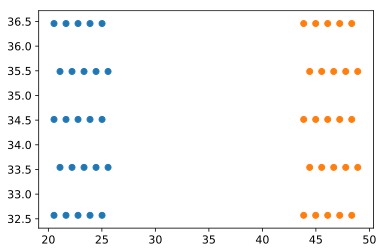

In [40]:
dt = 0.01                     # Zeitschrittweite in natürl. Einh.                     
dt_store = 0.05               # Zeitschrittweite für's Abspeichern
t_max = 125                   # Simulationsende in natürl. Einh.
xydim = 70                    # Abm. Sim.-gebiet in natürl. Einh.
vmax = 7.0

# Daten für Helium:
E_unit = 0.00094              # eV
t_unit = 1.76                 # ps 
T_unit = 10.9                 # K
m_unit = 4.0                  # u
v_unit = 150.0                # m/s
l_unit = 2.64                 # Angstrom
p_unit = 8122319              # Pa

xy1, v1, N1 = init_block(5, xydim/3, xydim/2, vmax, (0.0,0.0))
xy2,v2, N2 = init_block(5, xydim*2/3, xydim/2, vmax, (-0.2,0.0))

xy = np.concatenate((xy1,xy2),axis=1)
v = np.concatenate((v1, v2),axis=1)
N = N1+N2

plt.scatter(xy1[0], xy1[1]);
plt.scatter(xy2[0],xy2[1])

Wir sind jetzt bereit, eine Simulation der Flugbahnen durchzuführen:

In [32]:
times, traj, vel, E_pot, E_kin, p_star, p = do_calculation(
                                             xy, v, xydim, dt=dt, 
                                             t_max=t_max, 
                                             dt_store=dt_store)

In [33]:
times2, traj2, vel2, E_pot2, E_kin2, p_star2, p2 = do_calculation(
                                             np.array(traj[-1]), vel[-1], xydim, dt=dt, 
                                             t_max=t_max*2, 
                                             dt_store=dt_store, t0=times[-1])

Die Gesamtenergie im Simulationsgebiet sollte sich während der Simulation nicht ändern. Sie ist ein gutes Maß zur Überprüfung der Genauigkeit einer Simulation. Wir überprüfen also zunächst, ob die Energie im System konstant geblieben ist:

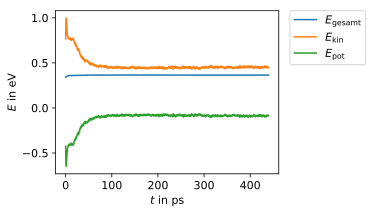

In [34]:
# Neuen Plot einrichten
plt.figure(figsize=(4, 3))
plt.ylabel('$E$ in eV')
plt.xlabel('$t$ in ps')
plt.plot(np.array(times+times2)*t_unit, 
         (np.array(E_kin+E_kin2)+np.array(E_pot+E_pot2))*E_unit,
         label='$E_{\mathrm{gesamt}}$')
plt.plot(np.array(times+times2)*t_unit, 
         np.array(E_kin+E_kin2)*E_unit, 
         label = "$E_{\mathrm{kin}}$")
plt.plot(np.array(times+times2)*t_unit, 
         np.array(E_pot+E_pot2)*E_unit, 
         label = "$E_{\mathrm{pot}}$")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Wir wollen jetzt die Bewegung der Teilchen in einer Animation sichtbar machen:

In [30]:
traj_gesamt = traj + traj2
vel_gesamt = vel + vel2

fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111,xlim=(0, xydim), 
                         ylim=(0, xydim), 
                     autoscale_on=False)

# die Positionen der Atome
atoms = ax.scatter(traj_gesamt[1][0], traj_gesamt[1][1], s=5,
                   c=np.sqrt(vel_gesamt[1][0]**2+vel_gesamt[1][1]**2), 
                   cmap='plasma')

def init():
    atoms.set_offsets([])
    atoms.set_array([])
    return atoms, 

def animate(i):
    atoms.set_offsets(traj_gesamt[i].T)
    v_abs = np.sqrt(vel_gesamt[i][0]**2+vel_gesamt[i][1]**2)
    atoms.set_array(v_abs)
    return atoms, 

anim = animation.FuncAnimation(fig, animate, frames=len(traj_gesamt),
                     interval=10, blit=True, init_func=init);

anim.save('animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.close(fig)

In [12]:
HTML(anim.to_html5_video())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### Verteilung der Teilchengeschwindigkeiten (Maxwell-Boltzmann-Verteilung)

Die Geschwindigkeiten der Atome in einem Gas, einer Flüssigkeit oder einem Festkörper sind nicht alle gleich, sondern über einen größeren Bereich verteilt. Für ein ideales Gas entspricht die Wahrscheinlichkeitsverteilung der Geschwindigkeitsbeträge der sog. [Maxwell-Boltzmann-Verteilung](https://de.wikipedia.org/wiki/Maxwell-Boltzmann-Verteilung). Diese lässt sich herleiten, wenn man davon ausgeht, dass die Teilchen ohne Vorzugsrichtung durch den Raum fliegen und die Geschwindigkeitskomponenten jeweils einer Normalverteilung unterliegen. Im Dreidimensionalen ergibt sich die Wahrscheinlichkeitsdichte-Verteilung (PDF) durch Multiplikation der drei Normalverteilungen für die drei Raumrichtungen zu:

$$p(v) = 4\pi\left(\frac{m_\text{Atom}}{2\pi k_\text{B} T}\right)^\frac{3}{2}v^2\exp\left(-\frac{m_\text{Atom}v^2}{2 k_\text{B} T} \right)$$

Im Zweidimensionalen ergibt sich:

$$p(v) = \frac{m_\text{Atom}}{k_\text{B} T}v \exp\left(-\frac{m_\text{Atom} v^2}{2 k_\text{B} T} \right)$$

Darin ist $k_\text{B} = 1.38064852\cdot 10^{-23}~\text{J/K}~$ die [Boltzmann-Konstante](https://de.wikipedia.org/wiki/Boltzmann-Konstante).

Es ist erstaunlich, dass die Teilchen unter sich völlig verlustfrei (reibungsfrei) interagieren. Wäre dies nicht so, würde sich das Gas in einem perfekt isolierten Behälter von allein abkühlen.

Im `SciPy`-Paket ist die Maxwell-Boltzmann-Verteilung bereits implementiert. Mit dem `fit`-Befehl lassen sich die Parameter der Verteilung aus einer gegebeben Datenreihe abschätzen.

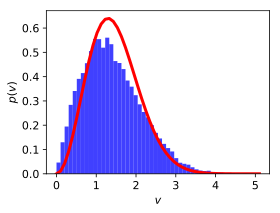

In [12]:
import scipy.stats as stats

plt.figure(figsize=(4, 3))

v2_abs = np.sqrt(vel2[-1][0]**2+vel2[-1][1]**2)
for i in range(2,1000):
    v2_abs = np.concatenate((v2_abs, 
                             np.sqrt(vel2[-i][0]**2+vel2[-i][1]**2)),
                           axis=0)

n, bins, patches = plt.hist(v2_abs, 50, 
                            normed=1, facecolor='blue', 
                            alpha=0.75);

maxwell = stats.maxwell
params = maxwell.fit(v2_abs, floc=0)

plt.plot(bins, maxwell.pdf(bins, *params), lw=3, color='red')
plt.xlabel('$v$')
plt.ylabel('$p(v)$');

Die mittlere Teilchengeschwindigkeit hat in idealen Gasen eine ähnliche Größenordnung wie die Schallgeschwindigkeit $a=\sqrt{\kappa R_s T}$. In unserem Beispiel mit Helium kommen wir auf eine Geschwindigkeit von:

In [13]:
v_mean = np.mean(v2_abs)*v_unit
print ('mittlere Teilchengeschwindigkeit in m/s:', v_mean)

mittlere Teilchengeschwindigkeit in m/s: 211.012522789


### Temperatur

Interessant ist es auch, die Temperatur im Simulationsgebiet über der Zeit darzustellen. Bei einem 1-atomigen Gas ist die kinetische Energie pro Freiheitsgrad des Atoms gerade $\frac{1}{2}k_\text{B} T$.

Die drei translatorischen Freiheitsgrade des 1-atomigen Gases - für jede Raumrichtung einer - führt also zu folgendem Zusammenhang zwischen der **mittleren** kinetischen Energie aller $N$ Atome und der Temperatur:

$$E_{\text{kin}} = \frac{3}{2}N k_\text{B} T$$

Im Zweidimensionalen ergibt sich dann:

$$E_{\text{kin,2D}} = 2\cdot\frac{1}{2}N k_\text{B} T$$

oder nach der Temperatur aufgelöst:

$$T = \frac{E_{\text{kin,2D}}}{N k_\text{B}}$$

Wenn wir damit die Temperatur über der Zeit auftragen bekommen wir folgendes Bild:

mittlere Temperatur:  13.6853343777


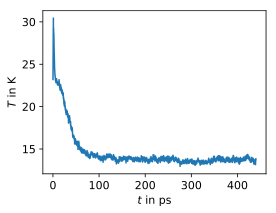

In [14]:
# Neuen Plot einrichten
plt.figure(figsize=(4, 3))
plt.ylabel('$T$ in K')
plt.xlabel('$t$ in ps')
plt.plot(np.array(times+times2)*t_unit, 
         np.array(E_kin+E_kin2)/N*T_unit);

print ("mittlere Temperatur: ", np.mean(E_kin2)/N*T_unit)

Da die Temperatur als Mittelwert der kinetischen Teilchenenergie definiert ist und wir verhältnismäßig wenige Atome simuliert haben, schwankt die Temperatur, auch nachdem das thermische Gleichgewicht eingetreten ist, noch deutlich. Wir mitteln deshalb über die zweite Simulation und kommen damit auf einen Wert von 13 K.

### Druck

Als nächstes soll der Druck im System berechnet werden. Dieser ist definiert als Kraft pro Fläche und Kraft ist Impulsänderung pro Zeit. Für unsere Box mit festen Wänden müssen wir also nur die beim Stoß mit der Wand hervorgerufene Impulsänderung der Teilchen über eine Zeitspanne aufsummieren und die Summe durch die Zeitspanne teilen:

$$p = \frac{\sum\limits_{i=1}^N 2\cdot m v_{n,i}}{\Delta t \cdot A}$$

Die oben definierte Funktion `do_calculation` liefert bereits den Druck mal eine  Tiefeneinheit (weil 2D) in natürlichen Einheiten zurück (`p_star`). Um zum Druck in Pa zu kommen, müssen wir diesen im Fall von Helium mit 8122319 und mit einer Längeneinheit multiplizieren.

Der Druck lässt sich aber auch direkt aus der Molekülbewegung und deren Interaktion aus der [Virialgleichung](https://de.wikipedia.org/wiki/Virialgleichungen) berechnen (vgl. Kapitel reale Arbeitsstoffe in der Thermodynamikvorlesung):

$$p = \underbrace{\frac{N k_B T}{V}}_{\text{wie ideales Gas}} + \underbrace{\frac{1}{3}\left<\sum\limits_{i<j}^N \overrightarrow{r}_{ij}\cdot \overrightarrow{F}_{ij} \right>}_{\text{Kräfte zw. den Molekülen}}$$

bzw. mit der Definition der Temperatur von oben:

$$p = \frac{N m_\text{Atom}}{3 N V} \left< 2E_{\text{kin}} + \sum\limits_{i<j}^N \overrightarrow{r}_{ij}\cdot \overrightarrow{F}_{ij} \right>$$

Aus der Gleichung wird deutlich, dass sich der Druck im Fluid aus der bereits bekannten Beziehung für ideale Gase $pV=m R_S T=n R_m T = N k_B T$ und einem zusätzlichen Term, der die zwischenmolekularen Kräfte berücksichtigt, zusammensetzt.

Die oben definierte Funktion `do_calculation` liefert den so berechneten Druck mal eine Tiefeneinheit (weil 2D) in natürlichen Einheiten zurück (`p`), allerdings noch ohne zeitliche Mittelung.

mittlerer Druck berechnet über Wandinteraktion:  0.000217745248901
mittlerer Druck berechnet über Virialgleichung:  0.000217758319005


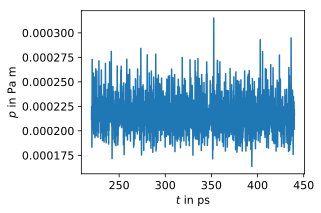

In [16]:
# Neuen Plot einrichten
plt.figure(figsize=(4, 3))
plt.ylabel('$p$ in Pa m')
plt.xlabel('$t$ in ps')
plt.plot(np.array(times2)*t_unit, 
         np.array(p2)*p_unit*l_unit*1e-10);

print ("mittlerer Druck berechnet über Wandinteraktion: ", 
       p_star2*p_unit*l_unit*1e-10)
print ("mittlerer Druck berechnet über Virialgleichung: ", 
       np.mean(p2)*p_unit*l_unit*1e-10)

### Dichte

Die Dichte $\rho$ kann aus der Atomanzahl, der Atommasse und der Größe des Simulationsgebiets berechnet werden:

$$\rho = \frac{m}{V} = \frac{N\cdot m_{\text{Atom}}}{xydim^3}$$

bzw. in 2D:

$$\rho_{\text{2D}} = \frac{N\cdot m_{\text{Atom}}}{xydim^2} \qquad \text{in }\frac{\text{kg}}{\text{m}^2}$$

### Innere Energie, spezifische Wärmekapazität und Isentropenexponent

Die **innere Energie** des Systems haben wir oben bereits berechnet. Sie setzt sich aus der kinetischen und der potentiellen Energie im Lennard-Jones-Kraftfeld zusammen. Bei einem 1-atomigen Gas wird die innere Energie nur durch die translatorische kinetische Energie der Moleküle bestimmt. D.h. wenn wir einem Behälter mit einem 1-atomigen Gas Energie zuführen, wird diese ausschließlich in die Erhöhung der kinetischen Teilchenenergie gehen. 

Bei mehratomigen Gasen kann Energie auch in Form von Rotations- und Schwingungsbewegungen zwischen den Molekülen gespeichert werden. Jeder Freiheitsgrad (FG) eines Moleküls kann genau $\frac{1}{2}k_B T$ Energie speichern. D.h. die innere Energie eines $n$-atomigen idealen Gases lässt sich dann wie folgt berechnen:

$$U = FG \cdot \frac{1}{2} N k_B T$$ bzw. $$u = FG \cdot \frac{1}{2} \frac{k_B T}{m_\text{Atom}} = FG \cdot \frac{1}{2} R T$$

Die **spezifische Enthalpie** ergibt sich definitionsgemäß für ein ideales Gas ($h=u+pv=u+RT$) zu

$$h = FG \cdot \frac{1}{2} R T + R T = \left(\frac{FG}{2}+1\right) R T$$

Das folgende Bild zeigt einige Beispiele für die Anregung von Freiheitsgraden je nach Form des Moleküls. Bei 2-atomigen Gasen kann auf der Achse zwischen den beiden Molekülen keine Rotationsenergie gespeichert werden, da das Trägheitsmoment um diese Achse vernachlässigbar klein ist. Schwingungsfreiheitsgrade werden bei Gasen erst bei sehr großer Temperatur (> 2000 K) voll angeregt und nehmen bei kleineren Temperaturen keine Energie auf.

![](Freiheitsgrade.pdf)

Der Isentropenexponent ergibt sich so direkt aus den Freiheitsgraden zu:

$$\kappa = \frac{h}{u} = \frac{FG+2}{FG}$$

|         | FG   | $\kappa$ |
| ------- |:----:| :-------:|
| 1-atomige Gase ($\text{He, Ne, Ar, Kr, Xe}$) | 3  | 1.66 |
| 2-atomige Gase ($\text{O}_2$, $\text{N}_2$, $\text{CO}$, ...) | 5  | 1.40 |
| 3-atomige Gase ($\text{CO}_2$, $\text{NO}_2$, ...)   | 6  | 1.33 |

In einem *Festkörper* wird die Energie dagegen zu etwa gleichen Teilen in Form von Schwingungen der Moleküle im Lennard-Jones-Kraftfeld und der kinetischen Energie gespeichert.

Die **spezifische Wärmekapazität bei konstantem Volumen** ist definiert als die Änderung der inneren Energie pro Temperaturänderung:

$$c_v = \frac{\partial u}{\partial T}\bigg\vert_v$$

Mithilfe der Molekular-Dynamik-Simulation lässt sich $c_v$ einfach bestimmen, indem zunächst die innere Energie ($U=E_{kin}+E_{pot}$) bei einer eingestellten Temperatur notiert wird. Anschließend erhöhen wir die Energie etwas (durch Erhöhung der Teilchengeschwindigkeiten) und bestimmen die neue Temperatur im Gleichgewicht. Die spez. Wärmekapazität ergibt sich dann einfach aus $c_v = \frac{\Delta U}{\Delta T}\frac{1}{N m_\text{Atom}}$.

Die **spezifische Wärmekapazität bei konstantem Druck** ist definiert als die Änderung der Enthalpie pro Temperaturänderung:

$$c_p = \frac{\partial h}{\partial T}\bigg\vert_p = \frac{\partial u+p\partial v}{\partial T}\bigg\vert_p = \frac{1}{N m_\text{Atom}}\frac{\partial U+p\partial V}{\partial T}\bigg\vert_p$$

Um $c_p$ aus der Simulation zu bestimmen, müssen wir Druck und Energie bei einem bestimmten Ausgangsvolumen bestimmen, dann das Volumen etwas vergrößern und solange die Energie des Systems erhöhen, bis der Druck wieder der gleiche wie im Ausgangszustand ist. Mit Hilfe der oben angegebenen Formel lässt sich dann $c_p$ bestimmen.

### Brownsche Bewegung und Diffusionsgeschwindigkeit

Beobachtet man eine Flüssigkeit mit kleinen Partikeln im Bereich weniger µm unter dem Mikroskop, so ist eine Bewegung zu erkennen, die an einen Betrunkenen erinnert, der willkürlich durch die Gegend taumelt. Der schottische Botaniker Robert Brown war der erste, der dies 1827 entdeckte. Die ursprüngliche Bezeichnung Brown'sche Molekularbewegung stammt noch aus einer Zeit, in der der Begriff Molekül ganz allgemein für keine Teilchen verwendet wurde. Er ist deshalb etwas irre führend, da es sich bei der Brownschen Bewegung um die Bewegung eines Verbundes mehrerer Atome oder Moleküle handelt.

Das folgende Video zeigt eine Mikroskopaufnahme von fluoreszierenden Latex-Kügelchen (20 nm Durchmesser) in Wasser bei einer 60-fachen Vergrößerung (J. Krieger, Deutsches Krebsforschungszentrum).

<a title="By J. Krieger am Deutschen Krebsforschungszentrum in der Arbeitsgruppe B040 Biophysik der Makromoleküle (Own work) [GFDL (http://www.gnu.org/copyleft/fdl.html), CC BY-SA 3.0 (http://creativecommons.org/licenses/by-sa/3.0) or CC BY-SA 3.0 de (http://creativecommons.org/licenses/by-sa/3.0/de/deed.en)], via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File%3ABrownianmotion_beads_in_water_spim_video.gif"><img width="256" alt="Brownianmotion beads in water spim video" src="https://upload.wikimedia.org/wikipedia/commons/5/5a/Brownianmotion_beads_in_water_spim_video.gif"/></a>

Die Bewegung rührt daher, dass die umgebenden Atome zufällig einen Impuls auf den Teilchenverbund ausüben. In diesem mikroskopischen Maßstab ist der Impuls nicht zu jedem Zeitpunkt ausgeglichen, so dass eine resultierende Kraft auf den Teilchenverbund wirkt, die zu der willkürlichen Bewegung führt.

Wir können das Verhalten mit unserem Simulationsprogramm sehr gut nachvollziehen, in dem wir ausgehend von einem kleinen Teilchenverbund die kinetische Energie erhöhen, bis sich so viele Atome aus dem Verbund gelöst haben, dass wir eine von Gas umgebene Flüssigkeit vorliegen haben. 

Wenn wir die Bewegung eines einzelnen Teilchens beobachten, werden wir feststellen, dass dieses nach kurzer Strecke willkürlich die Richtung ändert und ähnlich der Brownschen Bewegung durch den Raum zu taumeln scheint. Misst man nun die *Luftlinie*, die ein Teilchen in einer gegebenen Zeit von seinem Ausgangspunkt zurücklegt, so ist diese viel kürzer, als die gesamte zurückgelegte Strecke. Oder anders ausgedrückt, ist die **Diffusionsgeschwindigkeit** des Teilchens im Gas sehr viel kleiner, als die Teilchengeschwindigkeit selbst.

Mit einer Molekulardynamik-Simulation lassen sich also auch sehr gut Diffusionsgeschwindigkeiten von verschiedenen Stoffen in Gasen, Flüssigkeiten und Festkörpern simulieren. Im folgenden Diagramm ist die Bewegung eines einzelnen Atoms dargestellt:

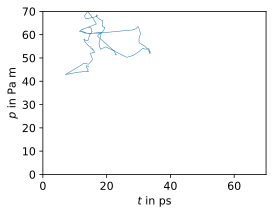

In [17]:
# Neuen Plot einrichten
plt.figure(figsize=(4, 3))
plt.ylabel('$p$ in Pa m')
plt.xlabel('$t$ in ps')

traj_np = np.array(traj2[:]).T
traj_x = traj_np[:][50][0]
traj_y = traj_np[:][50][1]

plt.xlim(0,xydim)
plt.ylim(0,xydim)
plt.plot(np.array(traj_x), 
         np.array(traj_y), lw=0.5);

### Aufgaben

1. Simulieren Sie die langsame Abkühlung eines Gases bis hin zur Kondensation.

2. Simulieren Sie die schnelle Abkühlung eines Gases.

3. Berechnen Sie die spezifische Wärmekapazität bei konst. Volumen $c_v$.

4. Berechnen Sie die spezifische Wärmekapazität bei konst. Druck $c_p$.

5. Erzeugen Sie einen Zustand nahe dem kritischen Punkt ($N=900$ Atome, $V=\text{xydim}^2=3*N$, $T=0.4 \dots 0.7$)

6. Ändern Sie den Code so ab, dass die Kollision von zwei Fluidballen mit unterschiedlicher Temperatur simuliert wird.

7. Simulieren Sie die Kompression eines Gases, in dem Sie ddie größe des Rechengebiets langsam verkleinern.

8. Überlagern Sie ein Gravitationskraftfeld und beobachten Sie die Gasdichte über der Höhe (xydim = 100, N=500, g=0.02, T=1).

9. Simulieren Sie die thermische Expansion eines Festkörpers.

10. Berechnen Sie die Ausbreitung einer Schallwelle in einem Festkörper.


---
###### Copyright (c) 2017, Matthias Stripf

Der folgende Python-Code darf ignoriert werden. Er dient nur dazu, die richtige Formatvorlage für die Jupyter-Notebooks zu laden.

In [18]:
from IPython.core.display import HTML
def css_styling():
    styles = open('TFDStyle.css', 'r').read()
    return HTML(styles)
css_styling()